
# Parviflo — Flip‑Risk Map & Hotspot Watch‑List (MVP Notebook)

This notebook creates an end‑to‑end **demo** of the Parviflo idea for a hackathon:
- Builds a **0.25° grid** over a small ocean basin (Mediterranean by default).
- Simulates **jellyfish observations**, **fish index**, and **environmental drivers** (SST, O₂, Chl‑a) to keep the notebook runnable without internet.
- Engineers features and trains a **logistic regression** to estimate **Flip‑Risk** (probability jellyfish dominate vs fish in the next months).
- Produces two judge‑ready outputs:
  1) **Flip‑Risk Map** — colored grid of risk for the next 6 months
  2) **Hotspot Watch‑List** — top zones where risk is rising the fastest

> **Live mode hooks** (OBIS, ICES, ERDDAP/WOA) are included as functions you can later wire to APIs when online. For the hackathon demo or offline judging, use the default **DEMO_MODE=True** to generate realistic synthetic signals and plots.


In [1]:

# --- Imports (only standard scientific stack) ---
import math, json, itertools, warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple, Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

warnings.filterwarnings("ignore")

# --- Config ---
DEMO_MODE = True  # keep True for offline demo; set False and implement the live fetchers if you have internet
np.random.seed(42)

# Basin (Mediterranean default)
BBOX = (-6.0, 30.0, 36.0, 46.0)  # (min_lon, min_lat, max_lon, max_lat)
GRID_DEG = 0.25  # 0.25 degree grid
MONTHS = pd.period_range("2018-01", "2024-12", freq="M")

# Outputs
OUT_DIR = "outputs_parviflo"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)


In [2]:

def make_grid(bbox, step):
    min_lon, min_lat, max_lon, max_lat = bbox
    lons = np.arange(min_lon, max_lon + 1e-9, step)
    lats = np.arange(min_lat, max_lat + 1e-9, step)
    lon2, lat2 = np.meshgrid(lons, lats)
    cells = pd.DataFrame({
        "lon": lon2.ravel(),
        "lat": lat2.ravel()
    })
    return cells

grid = make_grid(BBOX, GRID_DEG)
grid.head(), len(grid)


(    lon   lat
 0 -6.00  30.0
 1 -5.75  30.0
 2 -5.50  30.0
 3 -5.25  30.0
 4 -5.00  30.0,
 10985)


## Data (DEMO) generators


In [3]:

def seasonal_wave(t_idx, amplitude=1.0, phase=0.0):
    return amplitude * np.sin(2*np.pi*(t_idx/12.0) + phase)

def distance_to_coast(lat, lon):
    d_south = abs(lat - BBOX[1])
    d_north = abs(lat - BBOX[3])
    return np.minimum(d_south, d_north)

def demo_environment_series(grid: pd.DataFrame, months: pd.PeriodIndex) -> pd.DataFrame:
    rows = []
    for ti, p in enumerate(months):
        sst_base = 18.0 + seasonal_wave(ti, 6.0, phase=0.4)
        o2_base  = 5.8  - 0.02*(ti/12.0)
        chla_base = 1.2 + seasonal_wave(ti, 0.6, phase=-0.8)

        for _, r in grid.iterrows():
            lat, lon = r.lat, r.lon
            sst = sst_base + 0.02*(lon - BBOX[0]) + np.random.normal(0, 0.3)
            o2  = o2_base  - 0.005*(lat - BBOX[1]) + np.random.normal(0, 0.05)
            chla = chla_base + 0.004*((BBOX[2]-abs(lon-15))) + np.random.normal(0, 0.1)

            rows.append({
                "time": p.to_timestamp(how="end"),
                "lat": lat, "lon": lon,
                "sst": sst, "o2": o2, "chla": chla
            })
    return pd.DataFrame(rows)

def demo_biotic_series(env_df: pd.DataFrame) -> pd.DataFrame:
    df = env_df.copy()
    coast_d = distance_to_coast(df["lat"].values, df["lon"].values)
    coast_weight = np.exp(-coast_d/2.0)

    jelly_mu = 0.15*df["sst"].values + 0.35*df["chla"].values + 2.5*coast_weight + np.random.normal(0, 0.5, len(df))
    jelly_mu = np.clip(jelly_mu, 0.0, None)
    jelly_counts = np.random.poisson(lam=np.maximum(jelly_mu,1e-3))

    historic = 1.2*np.cos((df["lon"].values - 10)/6.0) + 0.6*np.cos((df["lat"].values - 38)/4.0)
    fish_raw = 1.8*df["o2"].values - 0.1*df["sst"].values + 0.8*historic + np.random.normal(0, 0.3, len(df))

    out = df[["time","lat","lon"]].copy()
    out["jelly_count"] = jelly_counts
    out["fish_index"] = fish_raw
    return out

env_df = demo_environment_series(grid, MONTHS)
bio_df = demo_biotic_series(env_df)

env_df.head(), bio_df.head()


(                           time   lat   lon        sst        o2      chla
 0 2018-01-31 23:59:59.999999999  30.0 -6.00  20.485524  5.793087  0.894355
 1 2018-01-31 23:59:59.999999999  30.0 -5.75  20.798419  5.788292  0.807173
 2 2018-01-31 23:59:59.999999999  30.0 -5.50  20.820274  5.838372  0.784639
 3 2018-01-31 23:59:59.999999999  30.0 -5.25  20.514278  5.776829  0.786013
 4 2018-01-31 23:59:59.999999999  30.0 -5.00  20.429099  5.704336  0.661095,
                            time   lat   lon  jelly_count  fish_index
 0 2018-01-31 23:59:59.999999999  30.0 -6.00            6    7.157358
 1 2018-01-31 23:59:59.999999999  30.0 -5.75            5    7.110173
 2 2018-01-31 23:59:59.999999999  30.0 -5.50            5    7.285947
 3 2018-01-31 23:59:59.999999999  30.0 -5.25            4    7.602903
 4 2018-01-31 23:59:59.999999999  30.0 -5.00            7    6.961281)


## Features & Labels


In [4]:

def monthly_climatology(df, var, years=(2018,2020)):
    base = df[(df["time"].dt.year>=years[0]) & (df["time"].dt.year<=years[1])].copy()
    base["month"] = base["time"].dt.month
    return base.groupby(["lat","lon","month"])[var].mean().rename(f"{var}_clim").reset_index()

def add_anomaly(df, var, clim):
    tmp = df.copy()
    tmp["month"] = tmp["time"].dt.month
    tmp = tmp.merge(clim, on=["lat","lon","month"], how="left")
    tmp[f"{var}_anom"] = tmp[var] - tmp[f"{var}_clim"]
    tmp.drop(columns=["month", f"{var}_clim"], inplace=True)
    return tmp

sst_clim = monthly_climatology(env_df, "sst", years=(2018,2020))
o2_clim  = monthly_climatology(env_df, "o2", years=(2018,2020))
chla_clim= monthly_climatology(env_df, "chla", years=(2018,2020))

envA = add_anomaly(env_df, "sst", sst_clim)
envA = add_anomaly(envA, "o2", o2_clim)
envA = add_anomaly(envA, "chla", chla_clim)

full = bio_df.merge(envA, on=["time","lat","lon"], how="left")

def jelly_index(series):
    return np.log1p(series)

def fish_index(series):
    return (series - series.mean())/ (series.std(ddof=0)+1e-6)

full["JellyIdx"] = full.groupby(["lat","lon"])["jelly_count"].transform(jelly_index)
full["FishIdx"]  = full.groupby(["lat","lon"])["fish_index"].transform(fish_index)

full["flip_label_now"] = (full["JellyIdx"] > (full["FishIdx"] + 0.3)).astype(int)

full.head()


,time,lat,lon,jelly_count,fish_index,sst,o2,chla,sst_anom,o2_anom,chla_anom,JellyIdx,FishIdx,flip_label_now
0,2018-01-31 23:59:59.999999999,30.0,-6.00,6,7.157358,20.485524,5.793087,0.894355,-0.053645,0.015024,0.075799,1.945910,-0.525034,1
1,2018-01-31 23:59:59.999999999,30.0,-5.75,5,7.110173,20.798419,5.788292,0.807173,0.551353,0.042790,-0.015603,1.791759,-0.811579,1
2,2018-01-31 23:59:59.999999999,30.0,-5.50,5,7.285947,20.820274,5.838372,0.784639,0.460124,0.005365,-0.031282,1.791759,-0.244026,1
3,2018-01-31 23:59:59.999999999,30.0,-5.25,4,7.602903,20.514278,5.776829,0.786013,0.017389,0.003728,-0.120717,1.609438,0.146534,1
4,2018-01-31 23:59:59.999999999,30.0,-5.00,7,6.961281,20.429099,5.704336,0.661095,-0.011816,-0.065919,-0.129312,2.079442,-0.915497,1


In [5]:

def build_samples(df: pd.DataFrame, lags=12, future_min=3, future_max=6):
    samples = []
    df = df.sort_values(["lat","lon","time"]).reset_index(drop=True)
    grouped = df.groupby(["lat","lon"], sort=False)
    for (lat, lon), g in grouped:
        g = g.reset_index(drop=True)
        for i in range(lags, len(g)-future_max):
            past = g.iloc[i-lags:i]
            fut  = g.iloc[i+future_min:i+future_max+1]
            if fut.empty: 
                continue
            feat = {"lat": lat, "lon": lon, "time": g.loc[i, "time"]}
            for var in ["JellyIdx","FishIdx","sst_anom","o2_anom","chla_anom"]:
                feat[f"{var}_last"] = past[var].iloc[-1]
                feat[f"{var}_mean12"] = past[var].mean()
                feat[f"{var}_std12"]  = past[var].std(ddof=0)
            y = 1 if fut["flip_label_now"].mean() >= 0.5 else 0
            feat["y_flip_future"] = y
            samples.append(feat)
    return pd.DataFrame(samples)

samples = build_samples(full, lags=12, future_min=3, future_max=6)
samples.shape, samples.head()


((725010, 19),
     lat  lon                          time  JellyIdx_last  JellyIdx_mean12  \
 0  30.0 -6.0 2019-01-31 23:59:59.999999999       1.386294         1.800559   
 1  30.0 -6.0 2019-02-28 23:59:59.999999999       1.791759         1.787713   
 2  30.0 -6.0 2019-03-31 23:59:59.999999999       2.197225         1.836695   
 3  30.0 -6.0 2019-04-30 23:59:59.999999999       1.945910         1.806972   
 4  30.0 -6.0 2019-05-31 23:59:59.999999999       1.791759         1.782998   
 
    JellyIdx_std12  FishIdx_last  FishIdx_mean12  FishIdx_std12  sst_anom_last  \
 0        0.330247      0.856802        0.381458       1.083645       0.163005   
 1        0.327329     -0.600433        0.375175       1.089088      -0.103050   
 2        0.340692     -0.971019        0.324842       1.135207      -0.127442   
 3        0.313200     -0.756930        0.340229       1.119073      -0.141257   
 4        0.302245     -0.474022        0.392471       1.063847      -0.011125   
 
    sst_anom_me


## Train a simple, explainable model


In [6]:

FEATURES = [c for c in samples.columns if c not in ["lat","lon","time","y_flip_future"]]
X = samples[FEATURES].values
y = samples["y_flip_future"].values

from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss

clf = LogisticRegression(max_iter=500, class_weight="balanced")
clf.fit(X_tr, y_tr)
probs = clf.predict_proba(X_te)[:,1]

auc = roc_auc_score(y_te, probs)
brier = brier_score_loss(y_te, probs)

print(f"AUC = {auc:.3f}  |  Brier = {brier:.3f}")


AUC = 0.810  |  Brier = 0.187



## Flip‑Risk Map (next 6 months)


In [7]:

def latest_month(df):
    return df["time"].max()

T_latest = latest_month(full)

def features_for_month(df, month, lags=12):
    out = []
    dfm = df[df["time"]<=month].copy()
    grouped = dfm.groupby(["lat","lon"], sort=False)
    for (lat, lon), g in grouped:
        g = g.sort_values("time")
        if len(g) < lags:
            continue
        past = g.iloc[-lags:]
        feat = {"lat": lat, "lon": lon}
        for var in ["JellyIdx","FishIdx","sst_anom","o2_anom","chla_anom"]:
            feat[f"{var}_last"] = past[var].iloc[-1]
            feat[f"{var}_mean12"] = past[var].mean()
            feat[f"{var}_std12"]  = past[var].std(ddof=0)
        out.append(feat)
    return pd.DataFrame(out)

X_latest = features_for_month(full, T_latest, lags=12)
X_latest_mat = X_latest[FEATURES].values
p_latest = clf.predict_proba(X_latest_mat)[:,1]

flipmap = X_latest[["lat","lon"]].copy()
flipmap["flip_risk"] = p_latest

flipmap.head(), flipmap["flip_risk"].describe()


(    lat   lon  flip_risk
 0  30.0 -6.00   0.838971
 1  30.0 -5.75   0.943676
 2  30.0 -5.50   0.946365
 3  30.0 -5.25   0.691310
 4  30.0 -5.00   0.946936,
 count    10985.000000
 mean         0.799341
 std          0.141593
 min          0.121192
 25%          0.725051
 50%          0.833300
 75%          0.907840
 max          0.996054
 Name: flip_risk, dtype: float64)

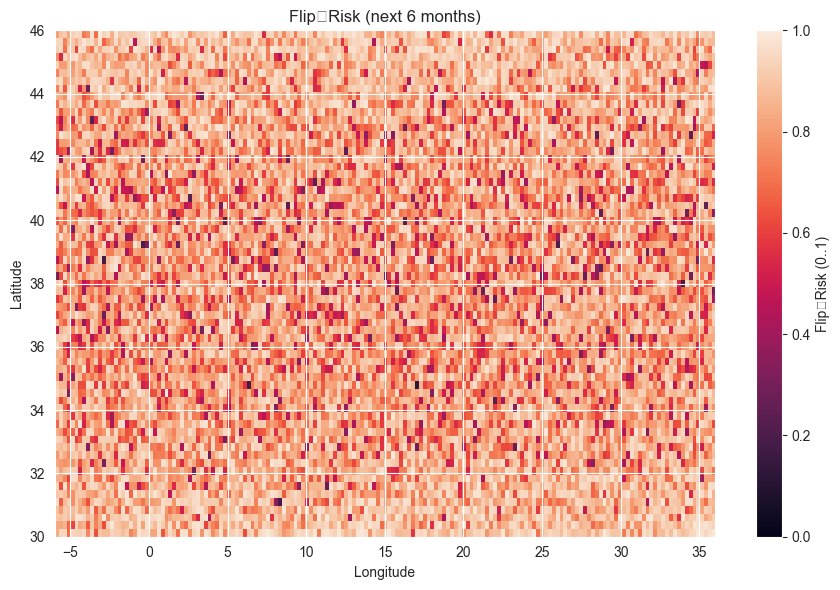

In [8]:

def plot_flipmap(df, title="Flip‑Risk (next 6 months)"):
    pivot = df.pivot_table(index="lat", columns="lon", values="flip_risk", aggfunc="mean")
    pivot = pivot.sort_index(ascending=True)
    plt.figure(figsize=(9,6))
    im = plt.imshow(pivot.values, origin="lower",
                    extent=[pivot.columns.min(), pivot.columns.max(), pivot.index.min(), pivot.index.max()],
                    vmin=0, vmax=1, aspect="auto")
    plt.colorbar(im, label="Flip‑Risk (0..1)")
    plt.title(title)
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.tight_layout()
    plt.savefig(f"outputs_parviflo/fliprisk_map.png", dpi=160)
    plt.show()

plot_flipmap(flipmap)



## Hotspot Watch‑List


In [9]:

def make_demo_zones():
    lon_splits = np.linspace(BBOX[0], BBOX[2], 4)
    lat_splits = np.linspace(BBOX[1], BBOX[3], 3)
    zones = []
    zid = 1
    for i in range(len(lat_splits)-1):
        for j in range(len(lon_splits)-1):
            zones.append({
                "zone_id": f"Z{zid}",
                "lat_min": float(lat_splits[i]), "lat_max": float(lat_splits[i+1]),
                "lon_min": float(lon_splits[j]), "lon_max": float(lon_splits[j+1])
            })
            zid += 1
    return pd.DataFrame(zones)

zones = make_demo_zones()
zones


,zone_id,lat_min,lat_max,lon_min,lon_max
0,Z1,30.0,38.0,-6.0,8.0
1,Z2,30.0,38.0,8.0,22.0
2,Z3,30.0,38.0,22.0,36.0
3,Z4,38.0,46.0,-6.0,8.0
4,Z5,38.0,46.0,8.0,22.0
5,Z6,38.0,46.0,22.0,36.0


In [10]:

def zone_join(df, zones):
    out = []
    for _, z in zones.iterrows():
        sel = df[(df["lat"]>=z.lat_min)&(df["lat"]<z.lat_max)&
                 (df["lon"]>=z.lon_min)&(df["lon"]<z.lon_max)]
        tmp = sel.copy()
        tmp["zone_id"] = z.zone_id
        out.append(tmp)
    if not out:
        return df.assign(zone_id="Z0")
    return pd.concat(out, ignore_index=True)

def monthly_predictions(df_full, months_back=12, lags=12):
    last_month = df_full["time"].max()
    months = pd.period_range((last_month - pd.offsets.MonthEnd(months_back)).to_period("M").start_time, last_month, freq="M")
    pred_rows = []
    for p in months:
        ctx = features_for_month(df_full, p.to_timestamp(how="end"), lags=lags)
        if ctx.empty: 
            continue
        probs = clf.predict_proba(ctx[FEATURES].values)[:,1]
        tmp = ctx[["lat","lon"]].copy()
        tmp["time"] = p.to_timestamp(how="end")
        tmp["flip_risk"] = probs
        pred_rows.append(tmp)
    return pd.concat(pred_rows, ignore_index=True) if pred_rows else pd.DataFrame(columns=["lat","lon","time","flip_risk"])

risk_series = monthly_predictions(full, months_back=12, lags=12)
risk_series.head()


,lat,lon,time,flip_risk
0,30.0,-6.00,2023-12-31 23:59:59.999999999,0.809414
1,30.0,-5.75,2023-12-31 23:59:59.999999999,0.829757
2,30.0,-5.50,2023-12-31 23:59:59.999999999,0.936064
3,30.0,-5.25,2023-12-31 23:59:59.999999999,0.943026
4,30.0,-5.00,2023-12-31 23:59:59.999999999,0.917428


In [11]:

from scipy.stats import theilslopes

def zone_watchlist(risk_series, zones):
    rz = zone_join(risk_series, zones)
    rows = []
    for zid, g in rz.groupby("zone_id"):
        if g.empty:
            continue
        mean_risk = g[g["time"]==g["time"].max()]["flip_risk"].mean()
        g2 = g.groupby("time")["flip_risk"].mean().reset_index()
        if len(g2) >= 3:
            x = (g2["time"] - g2["time"].min()).dt.days.values/30.0
            slope, intercept, _, _ = theilslopes(g2["flip_risk"].values, x)
        else:
            slope, intercept = np.nan, np.nan
        rows.append({"zone_id": zid, "mean_risk": mean_risk, "trend": slope})
    out = pd.DataFrame(rows)
    out["rank"] = out.sort_values(["trend","mean_risk"], ascending=[False,False])\
                     .reset_index(drop=True).index+1
    return out.sort_values(["rank"])

watchlist = zone_watchlist(risk_series, zones)
watchlist


,zone_id,mean_risk,trend,rank
0,Z1,0.799756,0.033499,1
1,Z2,0.796178,0.033294,2
2,Z3,0.804123,0.032530,3
3,Z4,0.794945,0.033419,4
4,Z5,0.797821,0.033771,5
5,Z6,0.794132,0.033363,6


In [12]:

# Save outputs
flipmap.to_csv(f"{OUT_DIR}/fliprisk_grid.csv", index=False)
watchlist.to_csv(f"{OUT_DIR}/hotspot_watchlist.csv", index=False)

payload = {
    "generated_at": pd.Timestamp.utcnow().isoformat(),
    "bbox": BBOX,
    "grid_deg": GRID_DEG,
    "fliprisk": flipmap.to_dict(orient="records"),
    "watchlist": watchlist.to_dict(orient="records")
}
with open(f"{OUT_DIR}/parviflo_payload.json","w") as f:
    json.dump(payload, f, indent=2)

print("Saved:")
print(f"- {OUT_DIR}/fliprisk_grid.csv")
print(f"- {OUT_DIR}/hotspot_watchlist.csv")
print(f"- {OUT_DIR}/parviflo_payload.json")
print(f"- {OUT_DIR}/fliprisk_map.png")


Saved:
- outputs_parviflo/fliprisk_grid.csv
- outputs_parviflo/hotspot_watchlist.csv
- outputs_parviflo/parviflo_payload.json
- outputs_parviflo/fliprisk_map.png



## What’s driving risk?


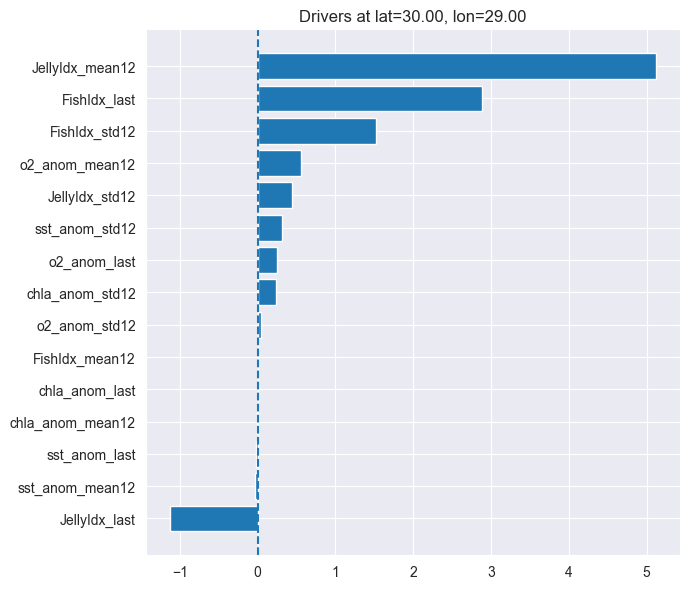

In [13]:

def plot_feature_contribs(clf, df_row, feature_names=FEATURES, title="Feature contributions"):
    coefs = clf.coef_[0]
    x = df_row[feature_names].values
    contribs = coefs * x
    order = np.argsort(contribs)
    names = np.array(feature_names)[order]
    vals = contribs[order]

    plt.figure(figsize=(7,6))
    y = np.arange(len(vals))
    plt.barh(y, vals)
    plt.yticks(y, names)
    plt.axvline(0, linestyle="--")
    plt.title(title)
    plt.tight_layout()
    plt.show()

cell_max = flipmap.sort_values("flip_risk", ascending=False).head(1)[["lat","lon"]].iloc[0]
row = X_latest[(X_latest["lat"]==cell_max["lat"]) & (X_latest["lon"]==cell_max["lon"])].iloc[0]
plot_feature_contribs(clf, row, title=f"Drivers at lat={row['lat']:.2f}, lon={row['lon']:.2f}")



## (Optional) Live‑mode fetchers (stubs)


In [14]:

def fetch_obis_jelly_month(bbox: tuple, year:int, month:int) -> pd.DataFrame:
    '''
    TODO: Implement OBIS/JeDI request and grid counts.
    Return columns: ['lat','lon','jelly_count'] for that (year, month)
    '''
    raise NotImplementedError("Implement when online.")

def fetch_ices_stock_table(assessment_key:int) -> pd.DataFrame:
    '''
    TODO: Implement ICES stock API fetch, compute fish index per area, map to grid.
    Return per grid cell: ['lat','lon','fish_index'] for a given month.
    '''
    raise NotImplementedError("Implement when online.")

def fetch_erddap_chla_month(bbox, year:int, month:int) -> pd.DataFrame:
    '''
    TODO: Fetch monthly mean chlorophyll from ERDDAP for bbox.
    Return columns: ['lat','lon','chla'] for that month.
    '''
    raise NotImplementedError("Implement when online.")



## Wrap‑up



- **Flip‑Risk Map** PNG and CSV (`outputs_parviflo/`)
- **Hotspot Watch‑List** CSV
- **JSON payload** for a web UI
- Clean pipeline you can switch to live data
